# Augment example

## Install env

In [1]:
# pip install git+https://github.com/Labbeti/MLU

## Prepare augments

In [2]:
from mlu.transforms import TimeStretchPadCrop, CutOutSpec, Occlusion, RandomChoice, Compose
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

/home/labbeti/anaconda3/envs/env_sslh/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
# Optional transform to spectrogram
n_mels = 64
n_time = 500
sr = 32000
n_fft = 2048
hop_length = sr * 10 // n_time

transform_to_spec = Compose(
    MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),
    AmplitudeToDB(),
)

TimeStretchPadCrop only resample signal waveform of length L to length (L * rate) and pad/crop it to return a waveform of length L.
The rate is uniformly sampled from a pre-defined range "rates".

CutOutSpec remove some value in a spectrogram by replacing value in a random rectangle area by -80.0 dB.
The width and height of the rectangle will be defined by scales (height_spec * height_scale, width_spec * width_scale),
where spectrogram has shape (height_spec, width_spec) and scales are uniformly generated in pre-defined ranges "width_scales" and "height_scales".

Occlusion replace a interval of values in the waveform by 0.
The length of this interval is defined by the scale uniformly sampled from the range "scales".

## Compose for weak augment

In [4]:
p = 0.5
augm = RandomChoice(
    Compose(
        TimeStretchPadCrop(rates=(0.9, 1.1), p=p),
        transform_to_spec,
    ),
    Compose(
        transform_to_spec,
        CutOutSpec(freq_scales=(0.1, 0.5), time_scales=(0.1, 0.5), fill_value=-80.0, p=p),
    ),
    Compose(
        Occlusion(scales=(0.1, 0.3), fill_value=0.0, p=p),
        transform_to_spec,
    ),
)

In [5]:
print(augm)

RandomChoice(
  (0): Compose(
    (0): TimeStretchPadCrop(
      (stretch): TimeStretch()
      (pad): Pad(target_length=1, align=random, fill_value=0.0, dim=-1, mode=constant)
      (crop): Crop(target_length=1, align=random, dim=-1)
    )
    (1): Compose(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
  )
  (1): Compose(
    (0): Compose(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
    (1): CutOutSpec()
  )
  (2): Compose(
    (0): Occlusion()
    (1): Compose(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
  )
)


## Test

In [6]:
import math
import torch

from matplotlib import pyplot as plt
from torch import Tensor

In [7]:
def gen_note(freq_note: float, duration: float, sample_rate: int, amplitude: float = 1.0) -> Tensor:
    nb_samples = duration * sample_rate
    x = torch.arange(start=0, end=nb_samples)
    note = amplitude * torch.sin(freq_note * x * 2.0 * math.pi / sample_rate)
    return note

# 0.5 Hz, 10 s
waveform = gen_note(0.5, 10, sr)
# Spec shape (mel, time) : (64, 501)
spec = transform_to_spec(waveform)
p = 1.0
stretch = TimeStretchPadCrop(rates=(0.5, 0.5), p=p)
cutout_spec = CutOutSpec(freq_scales=(0.4, 0.4), time_scales=(0.4, 0.4), fill_value=-80.0, p=p)
occlusion = Occlusion(scales=(0.4, 0.5))

/home/labbeti/anaconda3/envs/env_sslh/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/labbeti/anaconda3/envs/env_sslh/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window

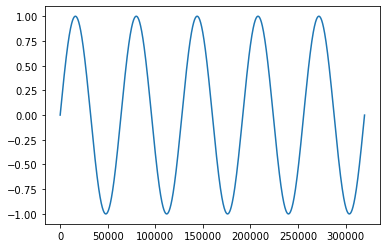

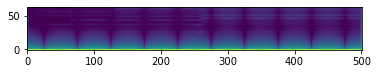

In [8]:
plt.plot(waveform)
plt.show()

plt.imshow(spec, origin="lower")
plt.show()

## TimeStretchPadCrop example:

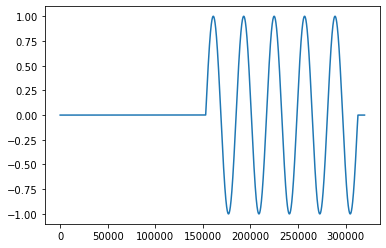

In [9]:
plt.plot(stretch(waveform))
plt.show()

## CutOutSpec example:

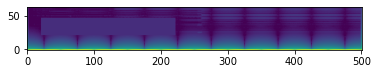

In [10]:
plt.imshow(cutout_spec(spec), origin="lower")
plt.show()

## Occlusion example:

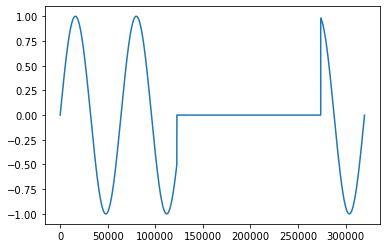

In [11]:
plt.plot(occlusion(waveform))
plt.show()

## Augments composed example:

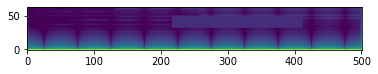

In [12]:
plt.imshow(augm(waveform), origin="lower")
plt.show()

## TimeStretchPadCrop on spec ?

In [13]:
stretch = TimeStretchPadCrop(rates=(0.5, 0.5), p=p)
waveform_stretch = stretch(waveform)
spec_stretch_1 = transform_to_spec(waveform_stretch)

stretch = TimeStretchPadCrop(rates=(0.5, 0.5), p=p, fill_value=-100.0)
spec_stretch_2 = stretch(spec)

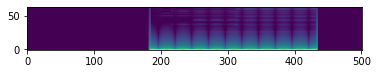

In [14]:
plt.imshow(spec_stretch_1, origin="lower")
plt.show()

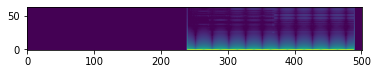

In [15]:
plt.imshow(spec_stretch_2, origin="lower")
plt.show()

## Occlusion on spec ?

In [16]:
occlusion = Occlusion(scales=(0.4, 0.4))
waveform_occlusion = occlusion(waveform)
spec_occlusion_1 = transform_to_spec(waveform_occlusion)

occlusion = Occlusion(scales=(0.4, 0.4), fill_value=-100.0)
spec_occlusion_2 = occlusion(spec)

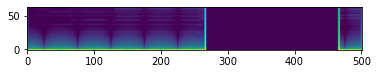

In [17]:
plt.imshow(spec_occlusion_1, origin="lower")
plt.show()

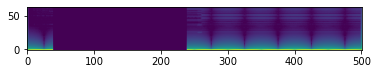

In [18]:
plt.imshow(spec_occlusion_2, origin="lower")
plt.show()


## Occlusion or CutOut ?

In [19]:
cutout_spec = CutOutSpec(freq_scales=(1.0, 1.0), time_scales=(0.4, 0.4), fill_value=-100.0)
spec_cutout_spec = cutout_spec(spec)

occlusion = Occlusion(scales=(0.4, 0.4), fill_value=-100.0)
spec_occlusion = occlusion(spec)

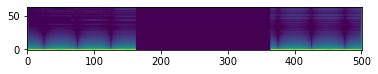

In [20]:
plt.imshow(spec_cutout_spec, origin="lower")
plt.show()

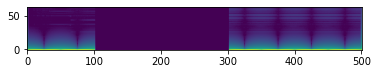

In [21]:
plt.imshow(spec_occlusion, origin="lower")
plt.show()

## Pitch Shift

In [22]:
from librosa.effects import pitch_shift

# print(spec.shape)
waveform_np = waveform.cpu().numpy()
waveform_ps = pitch_shift(waveform_np, sr, n_steps=4.0)
waveform_ps = torch.from_numpy(waveform_ps)

spec_ps = transform_to_spec(waveform_ps)

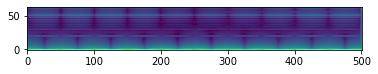

In [23]:
plt.imshow(spec_ps, origin="lower")
plt.show()

In [24]:
# from mlu.transforms.waveform.pitch_shift import PitchShift
# ps2 = PitchShift(sr, n_steps=4.0)
# waveform_ps2 = ps2(waveform)
# spec_ps2 = transform_to_spec(waveform_ps2)

In [25]:
# plt.imshow(spec_ps2, origin="lower")
# plt.show()


## CutOutSpec with other types of fill

In [26]:
cutout_spec = CutOutSpec(
	freq_scales=(0.5, 0.5),
	time_scales=(0.5, 0.5),
	fill_value=(-100, -80),
	fill_mode='random',
)

spec_cr = cutout_spec(spec)

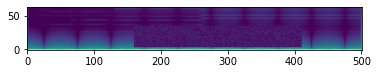

In [27]:
plt.imshow(spec_cr, origin="lower")
plt.show()


In [28]:
from mlu.transforms.fade import Fade
cutout_spec = CutOutSpec(
	freq_scales=(0.5, 0.5),
	time_scales=(0.5, 0.5),
	fill_mode=Fade(factor=0.5),
)

spec_cf = cutout_spec(spec)

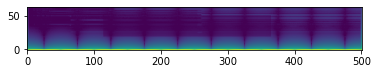

In [29]:
plt.imshow(spec_cf, origin="lower")
plt.show()

In [30]:
from mlu.transforms.noise import SubtractiveNoise
cutout_spec = CutOutSpec(
	freq_scales=(0.75, 0.75),
	time_scales=(0.75, 0.75),
	fill_mode=SubtractiveNoise(snr_db=15.0),
)

spec_cn = cutout_spec(spec)

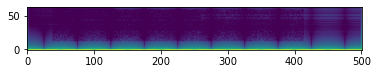

In [31]:
plt.imshow(spec_cn, origin="lower")
plt.show()

TimeStretch waveform or spec comparison

In [32]:
stretch = TimeStretchPadCrop(rates=(0.5, 0.5), p=p, align='left')
waveform_stretch = stretch(waveform)
spec_stretch_1 = transform_to_spec(waveform_stretch)

stretch = TimeStretchPadCrop(rates=(0.5, 0.5), p=p, fill_value=-100.0, align='left')
spec_stretch_2 = stretch(spec)

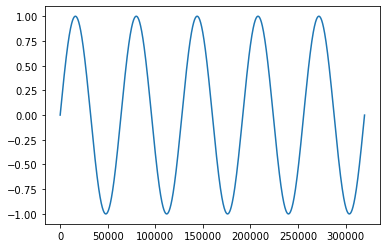

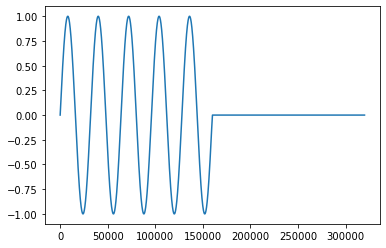

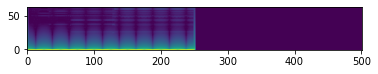

In [33]:
plt.plot(waveform)
plt.show()
plt.plot(waveform_stretch)
plt.show()
plt.imshow(spec_stretch_1, origin="lower")
plt.show()

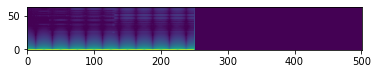

In [34]:
plt.imshow(spec_stretch_2, origin="lower")
plt.show()

In [35]:
diff = (spec_stretch_1 - spec_stretch_2).abs() + spec_stretch_1.min()


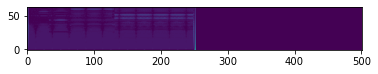

In [36]:
plt.imshow(diff, origin="lower")
plt.show()

TimeStretchPadCrop linear interpolation

In [37]:
from mlu.transforms import TimeStretch

# 0.5 Hz, 10 s
waveform2 = gen_note(20, 1, sr)

stretch_nearest = TimeStretch(rates=(0.5, 0.5), interpolation='nearest')
stretch_linear = TimeStretch(rates=(0.5, 0.5), interpolation='linear')

waveform2_stretch_nearest = stretch_nearest(waveform2)
waveform2_stretch_linear = stretch_linear(waveform2)

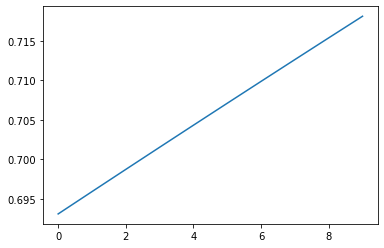

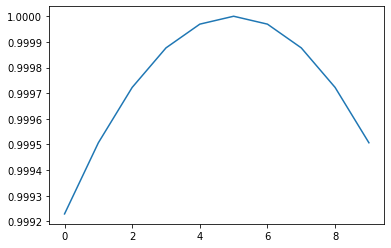

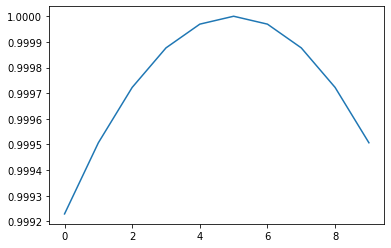

In [38]:
slices = slice(195, 205)

plt.plot(waveform2[slices])
plt.show()

plt.plot(waveform2_stretch_nearest[slices])
plt.show()

plt.plot(waveform2_stretch_linear[slices])
plt.show()

In [39]:
print(waveform2_stretch_nearest[slices].tolist())
print(waveform2_stretch_linear[slices].tolist())
print(waveform2_stretch_nearest.eq(waveform2_stretch_linear).all())

[0.9992290139198303, 0.9995065331459045, 0.999722421169281, 0.9998766183853149, 0.9999691843986511, 1.0, 0.9999691843986511, 0.9998766183853149, 0.999722421169281, 0.9995065331459045]
[0.9992290139198303, 0.9995065331459045, 0.999722421169281, 0.9998766183853149, 0.9999691843986511, 1.0, 0.9999691843986511, 0.9998766183853149, 0.999722421169281, 0.9995065331459045]
tensor(True)


CutOutSpec with different scales

In [47]:
cutoutspec_diff = CutOutSpec(freq_scales=(0.9, 1.0), time_scales=(0.0, 0.5))
spec_d = cutoutspec_diff(spec)

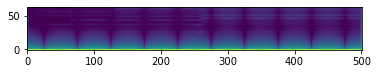

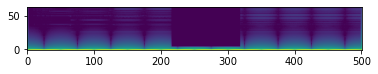

In [48]:
plt.imshow(spec, origin="lower")
plt.show()
plt.imshow(spec_d, origin="lower")
plt.show()